# CS4042 Data Engineering Group Project

In [50]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import unicodedata
from IPython.display import clear_output

### Preprecessing

In [51]:
sources = ['Player-Advanced-Stats', 'Player-Per-Game-Stats', 'Player-Shooting-Stats', 'Player-Totals-Stats']

# Dictionary for each folder
advanced = {}
per_game = {}
shooting = {}
totals = {}

for src in sources:

    src_path = os.path.join('Datasets', src)

    for file in os.listdir(src_path):
        
        file_path = os.path.join(src_path, file)
        name = file[4:-4] # Name of file

        # Assign DataFrame to correct dict
        if name[-1] == 'd':
            advanced[name] = pd.read_csv(file_path)
        elif name[-1] == 'G':
            per_game[name] = pd.read_csv(file_path)
        elif name[-1] == 'g':
            shooting[name] = pd.read_csv(file_path)
        else:
            totals[name] = pd.read_csv(file_path)



In [52]:
a = advanced['2022-23-Player-Stats-Advanced']
s = shooting['2022-23-Player-Stats-Shooting']
p = per_game['2022-23-Player-Stats-PG']
t = totals['2022-23-Player-Stats-Totals']

In [53]:
draftList = []

src_path = os.path.join('Datasets', "Drafts")

c = 2000

for file in os.listdir(src_path):
        
    file_path = os.path.join(src_path, file)

    temp = pd.read_csv(file_path,header=1)
    temp["Year"] = str(c)

    c+=1

    draftList.append(temp)

NBAMasterDrafts = pd.concat(draftList)
NBAMasterDrafts = NBAMasterDrafts[['Rk', 'Tm', 'Player', 'College', 'Year']]

folder = "Datasets/Master-Draft"
os.makedirs(folder, exist_ok=True)

MasterDraftFileName = "NBA-Master-Draft.csv"
MasterDraftFilePath = os.path.join(folder, MasterDraftFileName)
NBAMasterDrafts.to_csv(MasterDraftFilePath, index=False)
print(f"Saved: {MasterDraftFilePath}")

Saved: Datasets/Master-Draft\NBA-Master-Draft.csv


### Dirty Data - Ensure the quality of the pipeline

This section aims to create data quality issues within the tables to show that our pipeline can handle these concerns without problem. 

In [54]:
# Adds 'junk' column and fills it with empty strings.
def junk_col(df, col_name='junk'):
    if df.columns[-1] != col_name:
        df[col_name] = ''

# Add a fake leauge average summary row
def avg_row(df):
    if df.empty:
        return
    
    new_row = {col: np.nan for col in df.columns}
    if len(df.columns) > 1:
        second_col = df.columns[1]
        new_row[second_col] = "League Average"
    
    new_index = df.index.max() + 1 if len(df.index) > 0 else 0
    df.loc[new_index] = new_row

# Randomly duplicate rows
def dup_rows(df, n_dups=10, random_state=42):
    if len(df) == 0:
        return
    
    rng = np.random.default_rng(random_state)
    idx_pool = df.index[:-1] if len(df) > 1 else df.index  
    
    if len(idx_pool) == 0:
        return
    
    n_dups = min(n_dups, len(idx_pool))
    dup_indices = rng.choice(idx_pool, size=n_dups, replace=False)

    for idx in dup_indices:
        new_index = df.index.max() + 1
        df.loc[new_index] = df.loc[idx]

# add extra spaces
def add_whitespace(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include=["object"]).columns

    for col in columns:
        df[col] = df[col].apply(lambda v: f"  {v}  " if isinstance(v, str) else v)

# Convert Numeric values to strings
def numeric_to_string(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns

    for col in columns:
        df[col] = df[col].apply(lambda v: f" {v} " if pd.notna(v) else v)


In [55]:
def data_dirtier(advanced, per_game, shooting, totals, seed=42):
    for df in advanced.values():
        junk_col(df)
        dup_rows(df, random_state=seed)
        avg_row(df)
        avg_row(df)
        add_whitespace(df)

    for df in per_game.values():
        junk_col(df)
        dup_rows(df, random_state=seed)
        avg_row(df)
        add_whitespace(df)

    for df in shooting.values():
        junk_col(df)
        dup_rows(df, random_state=seed)
        avg_row(df)
        add_whitespace(df)
        numeric_to_string(df)  

    for df in totals.values():
        junk_col(df)
        dup_rows(df, random_state=seed)
        avg_row(df)
        add_whitespace(df)


data_dirtier(advanced, per_game, shooting, totals, seed=42)



### Clean Data - Fix Tables
This section aims to standardise the tables. Ensures there is only one header row, all datatypes are correct for columns, and removes redunant columns

In the case where there are two heading rows, merge them (only happens in shooting df)

In [56]:
def concatinate_headings(top_head, sub_head):
    heading = top_head + "_" + sub_head
    return heading

def clean_heading(heading, type):
    # Remove whitespace
    heading = heading.strip()

    # Replace spaces in text
    heading = heading.replace(" ", "_")

    # Remove trailing numbers in top_head
    if type == "top":
        if "." in heading:
            before, after = heading.rsplit(".", 1) # Splits at last "."
            if after.isdigit(): # if digits follow
                heading = before

    return heading

def logic(df):
    for column in df:
        # Break if there is only one heading
        if "Rk" in str(column):
            break
        # Skip if top heading doesn't have a value
        elif "Unnamed" in str(column):
            continue
        else:
            topheading = clean_heading(column, "top")
            subheading = clean_heading(df[column][0], "sub")
            output = concatinate_headings(topheading, subheading)
            df.loc[0, column] = output.strip()

# Apply changes
for df in shooting.values():
    logic(df)


Remove top headings and replace with concatinated headings done above (only happens in shooting)

In [57]:
def drop_irregular_headings(df):
    if df.columns[0] == "Unnamed: 0":
        df.columns = df.iloc[0]
        df.drop(index=0, inplace=True)
        df.reset_index(drop=True, inplace=True) # drop ensures previous index isn't repeated in the dataframe as a seperate column

# Apply changes
for df in shooting.values():
    drop_irregular_headings(df)

Ensure columns have correct data types (types only incorrect in shooting)
By default, that table's columns are all string objects

In [58]:
def check_type_is_digit(df):
    for column in df.columns:
        value = str(df[column][0]).strip()

        # Skip empty cells
        if value == None:
            continue

        if value == "":
            continue

        if value == "nan":
            continue

        # Convert strings to floats if they are a number or decimal
        try:
            float(value)
            df[column] = df[column].astype(float)
        except:
            continue

for df in shooting.values():
    check_type_is_digit(df)

Drop the last columns after Awards as they don't contain relevant data

In [59]:
for df in advanced.values():
    while df.columns[-1].strip() != "Awards":
        df.drop(df.columns[-1], axis=1, inplace=True)
for df in per_game.values():
    while df.columns[-1].strip() != "Awards":
        df.drop(df.columns[-1], axis=1, inplace=True)
for df in shooting.values():
    while df.columns[-1].strip() != "Awards":
        df.drop(df.columns[-1], axis=1, inplace=True)
for df in totals.values():
    while df.columns[-1].strip() != "Awards":
        df.drop(df.columns[-1], axis=1, inplace=True)

Drop rows where the majority of the cells are empty (irrelevant data) as well as average rows.

In [60]:
for df in advanced.values():
    df.columns = df.columns.str.strip()
    df.dropna(thresh=int(df.shape[1] * 0.4), inplace=True)
    df.drop(df[df['Player'].str.strip() == "League Average"].index, inplace=True)

for df in per_game.values():
    df.columns = df.columns.str.strip()
    df.dropna(thresh=int(df.shape[1] * 0.4), inplace=True)
    df.drop(df[df['Player'].str.strip() == "League Average"].index, inplace=True)

for df in shooting.values():
    df.columns = df.columns.str.strip()
    df.dropna(thresh=int(df.shape[1] * 0.4), inplace=True)
    df.drop(df[df['Player'].str.strip() == "League Average"].index, inplace=True)

for df in totals.values():
    df.columns = df.columns.str.strip()
    df.dropna(thresh=int(df.shape[1] * 0.4), inplace=True)
    df.drop(df[df['Player'].str.strip() == "League Average"].index, inplace=True)


Drop the final rows before relevant data

In [61]:
def check_if_numeric(df):
    try:
        value = int(df.iloc[-1, 0])
    except:
        return False
    else:
        return True
    
for df in advanced.values():
    while not check_if_numeric(df):
        df.drop(df.index[-1], axis=0, inplace=True)
        df.reset_index(drop=True, inplace=True)
for df in per_game.values():
    while not check_if_numeric(df):
        df.drop(df.index[-1], axis=0, inplace=True)
        df.reset_index(drop=True, inplace=True)
for df in shooting.values():
    while not check_if_numeric(df):
        df.drop(df.index[-1], axis=0, inplace=True)
        df.reset_index(drop=True, inplace=True)
for df in totals.values():
    while not check_if_numeric(df):
        df.drop(df.index[-1], axis=0, inplace=True)
        df.reset_index(drop=True, inplace=True)

### Clean Data - Making Data Analysis-Worthy

Check for duplicate rows and remove them

In [62]:
def remove_duplicates(df):
    df.drop_duplicates(inplace=True)

"""
Optionally, drop only by subset (eg. player, team).
This way if there is an error with the data, where the wrong team or player was placed in a cell, those will get dropped as well.
Even if other columns have different values.

def remove_duplicates(df):
    df.drop_duplicates(subset=["Player", "Team"], inplace=True)
"""

for df in advanced.values():
    remove_duplicates(df)
for df in per_game.values():
    remove_duplicates(df)
for df in shooting.values():
    remove_duplicates(df)
for df in totals.values():
    remove_duplicates(df)

Strip all data of whitespace

In [63]:
def strip_whitespace(df):
    df.iloc[0:] = df.iloc[0:].map(
        # Strips if value is a string object only
        lambda value: value.strip() if isinstance(value, str) else value
    )

for df in advanced.values():
    strip_whitespace(df)
for df in per_game.values():
    strip_whitespace(df)
for df in shooting.values():
    strip_whitespace(df)
for df in totals.values():
    strip_whitespace(df)

Convert common cell placeholders to NaN

In [64]:
def convert_to_nan(df):
    df.iloc[0:] = df.iloc[0:].map(
        # Convers to NaN if...
        lambda value: np.nan

        # Empty string
        if (isinstance(value, str) and value.strip() == "")

        # Other common placeholders
        or (isinstance(value, str) and "n/a" in str(value).lower())
        or (isinstance(value, str) and "null" in str(value).lower())
        or (isinstance(value, str) and str(value) == "?")
        or (isinstance(value, str) and "unknown" in str(value).lower())

        # Otherwise keep value
        else value
    )

for df in advanced.values():
    convert_to_nan(df)
for df in per_game.values():
    convert_to_nan(df)
for df in shooting.values():
    convert_to_nan(df)
for df in totals.values():
    convert_to_nan(df)

Remove any player whos played less than 5 games.

In [65]:
for df in advanced.values():
    df.drop(df[df['G'] < 5].index, inplace=True)
for df in per_game.values():
    df.drop(df[df['G'] < 5].index, inplace=True)
for df in shooting.values():
    df.drop(df[df['G'] < 5].index, inplace=True)
for df in totals.values():
    df.drop(df[df['G'] < 5].index, inplace=True)

Merge season tables into master tables.

In [66]:
from functools import reduce

# Removes padding on column names
def clean(df):
    df = df.copy()
    df.columns = df.columns.str.strip()
    return df

# Returns one row, per player, per season.
def row_return(df):
    df = df.copy()
    counts = df["Player"].value_counts()
    multi = df["Player"].isin(counts[counts > 1].index)
    return df[(~multi) | (df["Team"] == "TOT")].copy()

# Merge tables
def table_merge(base, other, how="left"):
    key = "Player"
    if key not in base.columns or key not in other.columns:
        raise KeyError(f"{key} must be a column in both DataFrames")
    new_cols = [c for c in other.columns if c not in base.columns or c == key]
    return pd.merge(base, other[new_cols], on=key, how=how)

# Create Master table per season
def build(season):
    adv_key = f"{season}-Player-Stats-Advanced"
    pg_key = f"{season}-Player-Stats-PG"
    shooting_key = f"{season}-Player-Stats-Shooting"
    totals_key = f"{season}-Player-Stats-Totals"

    adv = row_return(clean(advanced[adv_key]))
    pg = row_return(clean(per_game[pg_key]))
    shoot_df = row_return(clean(shooting[shooting_key]))
    tots = row_return(clean(totals[totals_key]))

    dfs_to_add = [pg, shoot_df, tots]

    master = reduce(
        lambda left, right: table_merge(left, right, how="left"),
        dfs_to_add,
        adv,
    )

    master["Season"] = season
    return master

# Build master tables for all seasons
seasons = ["2022-23", "2023-24", "2024-25", "2025-26"]
masters_by_season = {season: build(season) for season in seasons}
all_seasons_master = pd.concat(masters_by_season.values(), ignore_index=True)

# Quick View Examples

print("Shapes by season:")
for season, df in masters_by_season.items():
    print(season, df.shape)

print("\nPreview 2025-26 master:")
display(masters_by_season["2025-26"].head())

print("\nPreview all_seasons_master:")
display(all_seasons_master.head())


# Save as .csv inside 'Master-Stats' folder.
folder = "Datasets/Master-Stats"
os.makedirs(folder, exist_ok=True)

for season, df in masters_by_season.items():
    filename = f"NBA-{season}-Master-Stats.csv"
    filepath = os.path.join(folder, filename)
    df.to_csv(filepath, index=False)
    print(f"Saved: {filepath}")

all_seasons_filename = "NBA-All-Seasons-Master-Stats.csv"
all_seasons_filepath = os.path.join(folder, all_seasons_filename)
all_seasons_master.to_csv(all_seasons_filepath, index=False)
print(f"Saved: {all_seasons_filepath}")

Shapes by season:
2022-23 (440, 74)
2023-24 (466, 74)
2024-25 (459, 74)
2025-26 (400, 74)

Preview 2025-26 master:


,Rk,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,%_of_FG_Ast'd_2P,%_of_FG_Ast'd_3P,Dunks_%FGA,Dunks_#,Corner_3s_%3PA,Corner_3s_3P%,1/2_Court_Att.,1/2_Court_Md.,Trp-Dbl,Season
0,1.0,Devin Booker,29.0,PHO,SG,14.0,14.0,501.0,21.2,0.614,...,0.330,0.643,0.007,2.0,0.085,0.286,0.0,0.0,0.0,2025-26
1,2.0,Franz Wagner,24.0,ORL,SF,14.0,14.0,501.0,19.0,0.587,...,0.506,0.840,0.022,5.0,0.143,0.400,0.0,0.0,0.0,2025-26
2,3.0,Tyrese Maxey,25.0,PHI,PG,12.0,12.0,484.0,23.4,0.597,...,0.370,0.674,0.025,6.0,0.055,0.500,0.0,0.0,0.0,2025-26
3,4.0,Cooper Flagg,19.0,DAL,PG,14.0,14.0,478.0,12.6,0.526,...,0.333,0.800,0.080,11.0,0.218,0.000,0.0,0.0,0.0,2025-26
4,5.0,DeMar DeRozan,36.0,SAC,PF,14.0,14.0,476.0,15.9,0.585,...,0.523,1.000,0.000,0.0,0.545,0.500,0.0,0.0,0.0,2025-26



Preview all_seasons_master:


,Rk,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,%_of_FG_Ast'd_2P,%_of_FG_Ast'd_3P,Dunks_%FGA,Dunks_#,Corner_3s_%3PA,Corner_3s_3P%,1/2_Court_Att.,1/2_Court_Md.,Trp-Dbl,Season
0,2.0,Anthony Edwards,21.0,MIN,SG,79.0,79.0,2842.0,17.4,0.564,...,0.348,0.516,0.044,59.0,0.097,0.446,3.0,0.0,0.0,2022-23
1,3.0,Zach LaVine,27.0,CHI,SG,77.0,77.0,2768.0,19.0,0.607,...,0.335,0.647,0.042,56.0,0.138,0.467,0.0,0.0,0.0,2022-23
2,4.0,Nikola Vučević,32.0,CHI,C,82.0,82.0,2746.0,19.1,0.594,...,0.735,1.000,0.039,37.0,0.124,0.465,0.0,0.0,1.0,2022-23
3,5.0,Julius Randle,28.0,NYK,PF,77.0,77.0,2737.0,20.3,0.581,...,0.382,0.752,0.051,62.0,0.142,0.333,2.0,0.0,0.0,2022-23
4,6.0,Domantas Sabonis,26.0,SAC,C,79.0,79.0,2736.0,23.5,0.668,...,0.570,0.968,0.092,79.0,0.120,0.200,1.0,0.0,14.0,2022-23


Saved: Datasets/Master-Stats\NBA-2022-23-Master-Stats.csv
Saved: Datasets/Master-Stats\NBA-2023-24-Master-Stats.csv
Saved: Datasets/Master-Stats\NBA-2024-25-Master-Stats.csv
Saved: Datasets/Master-Stats\NBA-2025-26-Master-Stats.csv
Saved: Datasets/Master-Stats\NBA-All-Seasons-Master-Stats.csv


Function to create bar graph based on inputted column name.

Example:


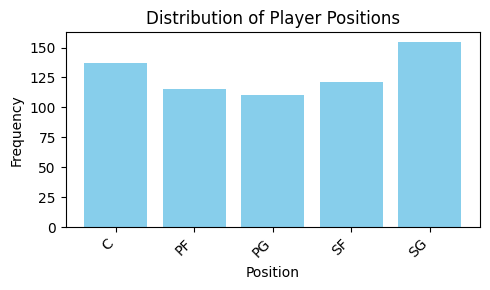

In [67]:
def create_bar_graph(df, x_column, title=None, xlabel=None, ylabel='Frequency', figsize=(5, 3), color='skyblue'):

    if x_column not in df.columns:
        raise ValueError(f"Column '{x_column}' not found in DataFrame")
    
    value_counts = df[x_column].value_counts().sort_index()
    
    plt.figure(figsize=figsize)
    plt.bar(value_counts.index, value_counts.values, color=color)
    plt.xlabel(xlabel if xlabel else x_column)
    plt.ylabel(ylabel)
    plt.title(title if title else f'Distribution of {x_column}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example
print("Example:")
create_bar_graph(p, 'Pos', title='Distribution of Player Positions', xlabel='Position')

Function to create a scatterplot based on inputted x and y.

Example:


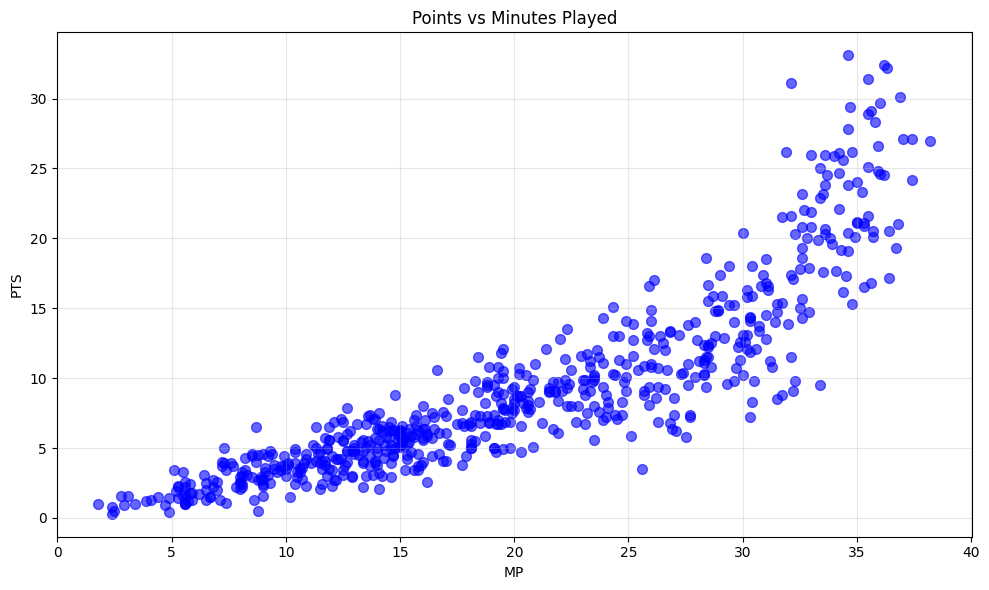

In [68]:
def create_scatter_plot(df, x_column, y_column, title=None, xlabel=None, ylabel=None, 
                       figsize=(10, 6), color='blue', alpha=0.6, s=50):

    clean_df = df[[x_column, y_column]].dropna()
    
    plt.figure(figsize=figsize)
    plt.scatter(clean_df[x_column], clean_df[y_column], color=color, alpha=alpha, s=s)
    plt.xlabel(xlabel if xlabel else x_column)
    plt.ylabel(ylabel if ylabel else y_column)
    plt.title(title if title else f'{y_column} vs {x_column}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example
print("Example:")
create_scatter_plot(p, 'MP', 'PTS', title='Points vs Minutes Played')

Function to normalise names (remove special characters like ć).

In [69]:
def normalizeName(name):

    name = str(name)

    nfkd_form = unicodedata.normalize('NFKD', name)
    only_ascii = nfkd_form.encode('ASCII', 'ignore').decode('utf-8')
    return only_ascii.lower()

Function to visualise player shooting percentages by position on the court.

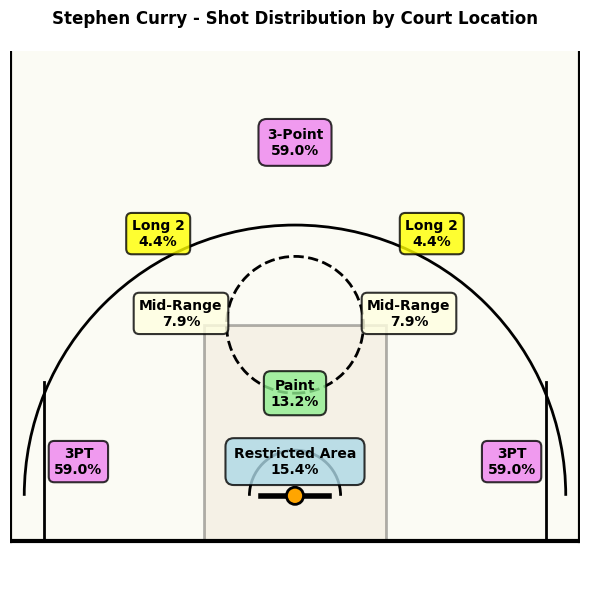

True

In [70]:
def visualize_player_shooting_positions(df, player_name, figsize=(6, 6)):
    # Normalize the input player name
    name_normalized = normalizeName(player_name)
    
    # Create a normalized column for comparison
    df_temp = df.copy()
    df_temp['PlayerNorm'] = df_temp['Player'].apply(normalizeName)
    
    # Search using normalized names
    player_data = df_temp[df_temp['PlayerNorm'] == name_normalized]
    
    if player_data.empty:
        print(f"Player '{player_name}' not found in the dataset.")
        return False
    
    player_row = player_data.iloc[0]
    
    # get shooting percentages from different distances
    zones = {
        'Restricted Area': player_row.get('%_of_FGA_by_Distance_0-3', 0),
        'Paint (Non-RA)': player_row.get('%_of_FGA_by_Distance_3-10', 0),
        'Mid-Range': player_row.get('%_of_FGA_by_Distance_10-16', 0),
        'Long Mid-Range': player_row.get('%_of_FGA_by_Distance_16-3P', 0),
        '3-Point': player_row.get('%_of_FGA_by_Distance_3P', 0)
    }
    
    # convert to numeric, handle NaN, and convert from decimal to percentage (doesnt work otherwise as everything displays 0)
    for key in zones:
        try:
            value = zones[key]
            if pd.notna(value):
                zones[key] = float(value) * 100  # Convert decimal to percentage
            else:
                zones[key] = 0
        except (ValueError, TypeError):
            zones[key] = 0
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # court dimensions 
    court_length = 23.5  # Half court length 
    court_width = 25     # court width
    
    ax.set_xlim(-12.5, 12.5)
    ax.set_ylim(-2, 21.5)
    ax.set_aspect('equal')
    
    # Court outline
    ax.plot([-12.5, 12.5], [0, 0], 'k-', linewidth=3)  # Baseline
    ax.plot([-12.5, -12.5], [0, 23.5], 'k-', linewidth=3)  # Left sideline
    ax.plot([12.5, 12.5], [0, 23.5], 'k-', linewidth=3)  # Right sideline
    ax.plot([-12.5, 12.5], [23.5, 23.5], 'k-', linewidth=3)  # Half court line
    
    # Paint
    paint_width = 8
    paint_length = 9.5
    paint = patches.Rectangle((-paint_width/2, 0), paint_width, paint_length, linewidth=2, edgecolor='black', facecolor='#e8dcc8', alpha=0.3)
    ax.add_patch(paint)
    
    # Free throw circle
    free_throw_circle = patches.Circle((0, 9.5), 3, linewidth=2, edgecolor='black', fill=False, linestyle='--')
    ax.add_patch(free_throw_circle)
    
    # Restricted area arc
    restricted = patches.Arc((0, 2), 4, 4, theta1=0, theta2=180, linewidth=2, edgecolor='black')
    ax.add_patch(restricted)
    
    # Three-point arc
    three_point_radius = 11.875
    three_point_arc = patches.Arc((0, 2), 2*three_point_radius, 2*three_point_radius, theta1=0, theta2=180, linewidth=2, edgecolor='black')
    ax.add_patch(three_point_arc)
    
    # Three-point straight lines in corners
    ax.plot([-12.5, -11], [0, 0], 'k-', linewidth=2)  # Left corner
    ax.plot([11, 12.5], [0, 0], 'k-', linewidth=2)   # Right corner
    ax.plot([-11, -11], [0, 7], 'k-', linewidth=2)  # Left corner line
    ax.plot([11, 11], [0, 7], 'k-', linewidth=2)   # Right corner line
    
    # Backboard
    ax.plot([-1.5, 1.5], [2, 2], 'k-', linewidth=4)
    
    # Rim
    rim = patches.Circle((0, 2), 0.375, linewidth=2, edgecolor='black', facecolor='orange', zorder=10)
    ax.add_patch(rim)
    
    # Add zone and all the styling needed
    
    small = 10

    # Restricted Area
    ax.text(0, 3.5, f"Restricted Area\n{zones['Restricted Area']:.1f}%", ha='center', va='center', fontsize=small, weight='bold', bbox=dict(boxstyle='round,pad=0.6', facecolor='lightblue', alpha=0.8, edgecolor='black', linewidth=1.5))
    
    # Paint (Non-RA)
    ax.text(0, 6.5, f"Paint\n{zones['Paint (Non-RA)']:.1f}%", ha='center', va='center', fontsize=small, weight='bold', bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8, edgecolor='black', linewidth=1.5))
    
    # Mid-Range 
    ax.text(-5, 10, f"Mid-Range\n{zones['Mid-Range']:.1f}%", ha='center', va='center', fontsize=small, weight='bold', bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', alpha=0.8, edgecolor='black', linewidth=1.5))
    ax.text(5, 10, f"Mid-Range\n{zones['Mid-Range']:.1f}%", ha='center', va='center', fontsize=small, weight='bold', bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', alpha=0.8, edgecolor='black', linewidth=1.5))
    
    # Long Mid-Range
    ax.text(-6, 13.5, f"Long 2\n{zones['Long Mid-Range']:.1f}%", ha='center', va='center', fontsize=small, weight='bold', bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.8, edgecolor='black', linewidth=1.5))
    ax.text(6, 13.5, f"Long 2\n{zones['Long Mid-Range']:.1f}%", ha='center', va='center', fontsize=small, weight='bold', bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.8, edgecolor='black', linewidth=1.5))
    
    # 3-Point zones 
    ax.text(-9.5, 3.5, f"3PT\n{zones['3-Point']:.1f}%", ha='center', va='center', fontsize=small, weight='bold', bbox=dict(boxstyle='round,pad=0.4', facecolor='violet', alpha=0.8, edgecolor='black', linewidth=1.5))
    ax.text(9.5, 3.5, f"3PT\n{zones['3-Point']:.1f}%", ha='center', va='center', fontsize=small, weight='bold', bbox=dict(boxstyle='round,pad=0.4', facecolor='violet', alpha=0.8, edgecolor='black', linewidth=1.5))
    ax.text(0, 17.5, f"3-Point\n{zones['3-Point']:.1f}%", ha='center', va='center', fontsize=small, weight='bold', bbox=dict(boxstyle='round,pad=0.6', facecolor='violet', alpha=0.8, edgecolor='black', linewidth=1.5))
    
    #can adjust these dimensions as needed but generally works fine for visualisation
    
    # Add court background color
    court_bg = patches.Rectangle((-12.5, 0), 25, 23.5, linewidth=0, 
                                 facecolor='beige', alpha=0.3, zorder=-1)
    ax.add_patch(court_bg)
    
    ax.set_title(f"{player_name} - Shot Distribution by Court Location", fontsize=12, weight='bold', pad=20)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return True

visualize_player_shooting_positions(df, "Stephen Curry")

KNN function, checks the most similar player to input player (other than player, of course).

In [71]:
def KNN(df, name):

    k = 5 # ensures it doesnt find the same person for all the entries (one guy can appear up to 4 times)

    name = normalizeName(name)

    df["PlayerNorm"] = df["Player"].apply(normalizeName)

    if name not in df["PlayerNorm"].values:
        return False
    
    playerIndex = df.index[df["PlayerNorm"] == name][0]

    X = df.drop("Player", axis=1)
    
    # Separate numeric and categorical columns
    numFeatures = X.select_dtypes(include=["int64", "float64"]).columns
    catFeatures = X.select_dtypes(include=["object", "category"]).columns
    
    # Fill missing values
    X[numFeatures] = X[numFeatures].fillna(0)
    X[catFeatures] = X[catFeatures].fillna("missing")
    
    # Convert categorical to string
    for col in catFeatures:
        X[col] = X[col].astype(str)
    
    # Preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numFeatures),
            ("cat", OneHotEncoder(), catFeatures)
        ]
    )
    
    X_processed = preprocessor.fit_transform(X)
    
    # Fit NearestNeighbors
    NN = NearestNeighbors(n_neighbors=k, metric='euclidean')
    NN.fit(X_processed)
    
    distances, indices = NN.kneighbors(X_processed[playerIndex])
    
    # Exclude the player themselves
    neighbors = []
    neighbor_distances = []
    
    for idx, dist in zip(indices[0], distances[0]):
        if df.iloc[idx]["PlayerNorm"] != name:
            neighbors.append(idx)
            neighbor_distances.append(dist)
        if len(neighbors) >= k:
            break
    
    result = df.iloc[neighbors[0]]["Player"]

    print(result)

    return True

Drafted function, checks what year the player was drafted in.

In [72]:
def drafted(name, df=NBAMasterDrafts):
    
    name = normalizeName(name)

    df["PlayerNorm"] = df["Player"].apply(normalizeName)

    if name not in df["PlayerNorm"].values:
        return False
    
    row = df[df["PlayerNorm"] == name]

    print(row["Year"].iloc[0])
    return True

Run loop, allows user to selectively use functions.

In [74]:
clear_output()

menu = True

while menu:
    print("\n0 : Exit")
    print("\n1 : Find most similar player")
    print("\n2 : Drafted years for players")
    print("\n3 : View Player's shot distribution by court location")
    print("\n4 : View Scatter plot of two statistics")
    print("\n5 : View bar graph distribution of a statistic")
    print("\nPlease select a number :")
    x = input().strip()
    print("\n")


    if x == "0":
        clear_output()
        print("Goodbye !")
        break
    
    elif x == "1":

        KNNmenu = True

        while KNNmenu:

            Yearmenu = True

            while Yearmenu:

                clear_output()

                print("\nPlease enter the year you wish to search within. (2022, 2023, 2024, 2025) / exit with 0")
                y = input().strip()

                clear_output()

                if y == "0":
                    print("Returned back to main menu")
                    KNNmenu = False
                    break

                elif y == "2022":
                    yearDF = all_seasons_master[all_seasons_master.Season == "2022-23"].reset_index(drop=True)
                    #print(yearDF.head(10))
                    break

                elif y == "2023":
                    yearDF = all_seasons_master[all_seasons_master.Season == "2023-24"].reset_index(drop=True)
                    #print(yearDF.head(10))
                    break

                elif y == "2024":
                    yearDF = all_seasons_master[all_seasons_master.Season == "2024-25"].reset_index(drop=True)
                    #print(yearDF.head(10))
                    break

                elif y == "2025":
                    yearDF = all_seasons_master[all_seasons_master.Season == "2025-26"].reset_index(drop=True)
                    #print(yearDF.head(10))
                    break

            if KNNmenu == False:
                break

            Playermenu = True

            while Playermenu:

                print("\nPlease enter the player you wish to search from. (full name) / exit with 0")
                z = input().strip()

                if z == "0":
                    clear_output()
                    print("Returned back to main menu")
                    KNNmenu = False
                    break

                else:
                    clear_output()
                    found = KNN(yearDF,z)

                if found:
                    KNNmenu = False
                    break
                else:
                    clear_output()
                    print(z+" not found in database")

            if KNNmenu == False:
                break

    elif x == "2":

        clear_output()

        Draftmenu = True

        while Draftmenu:

            print("\nPlease enter the player you wish to see the drafted year for. (full name) / exit with 0")
            y = input().strip()

            if y == "0":
                clear_output()
                print("Returned back to main menu")
                Draftmenu = False
                break

            else:
                clear_output()
                found = drafted(y)

            if found:
                Draftmenu = False
                break
            else:
                clear_output()
                print(y+" not found in database")

    elif x == "3":

        clear_output()

        Shotmenu = True

        while Shotmenu:

            print("\nPlease enter the player you wish to see the shot distribution for. (full name) / exit with 0")
            y = input().strip()

            if y == "0":
                clear_output()
                print("Returned back to main menu")
                Shotmenu = False
                break

            else:
                clear_output()
                found = visualize_player_shooting_positions(s, y)

            if found:
                Shotmenu = False
                break
            else:
                clear_output()
                print(y+" not found in database")

    elif x == "4":

        clear_output()

        Scattermenu = True

        while Scattermenu:

            print("\nPlease enter the first statistic for the scatter graph. / exit with 0")
            print("Suggested statistics: PTS, AST, TRB, STL, BLK, MP, FG%, 3P%, TS%, PER, USG%")
            stat1 = input().strip()

            if stat1 == "0":
                clear_output()
                print("Returned back to main menu")
                Scattermenu = False
                break

            print("\nPlease enter the second statistic for the scatter graph. / exit with 0")
            print("Suggested statistics: PTS, AST, TRB, STL, BLK, MP, FG%, 3P%, TS%, PER, USG%")
            stat2 = input().strip()

            if stat2 == "0":
                clear_output()
                print("Returned back to main menu")
                Scattermenu = False
                break

            clear_output()

            # Validate columns exist
            if stat1 not in all_seasons_master.columns:
                print(f"'{stat1}' not found in database. Please check the column name.")
                continue
            
            if stat2 not in all_seasons_master.columns:
                print(f"'{stat2}' not found in database. Please check the column name.")
                continue

            # Create the scatter plot
            try:
                create_scatter_plot(all_seasons_master, stat1, stat2, 
                                  title=f'{stat2} vs {stat1}')
                Scattermenu = False
                break
            except Exception as e:
                print(f"Error creating scatter plot: {e}")
                print("Please try different statistics.")
                continue

    elif x == "5":

        clear_output()

        Barmenu = True

        while Barmenu:

            print("\nPlease enter the statistic you want to see in the bar graph. / exit with 0")
            print("Suggested statistics: Pos, Age, G")
            stat = input().strip()

            if stat == "0":
                clear_output()
                print("Returned back to main menu")
                Barmenu = False
                break

            clear_output()

            # Validate column exists
            if stat not in all_seasons_master.columns:
                print(f"'{stat}' not found in database. Please check the column name.")
                continue

            # Create the bar graph
            try:
                create_bar_graph(all_seasons_master, stat, 
                               title=f'Distribution of {stat}')
                Barmenu = False
                break
            except Exception as e:
                print(f"Error creating bar graph: {e}")
                print("Please try a different statistic.")
                continue

    else:
        clear_output()
        print("That is not a valid entry")

Goodbye !
